In [6]:
import pandas as pd
import numpy as np
import joblib
!pip install plydata
import plydata.cat_tools as cat_tools
import plotnine as pn
pn.options.dpi = 300

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from google.cloud import bigquery
from google.colab import auth


#authenticate
auth.authenticate_user()

#initialize the client for Bigquery
project_id = 'keen-phalanx-396514'
client = bigquery.Client(project_id, location='US')

In [7]:
# Get the dataset and 1st table
dataset_ref = client.dataset('For_Practice', project=project_id)
dataset = client.get_dataset(dataset_ref)
table_ref = dataset.table('cdnow_dataset')
table = client.get_table(table_ref)
table.schema

[SchemaField('int64_field_0', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('customer_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('date', 'DATE', 'NULLABLE', None, None, (), None),
 SchemaField('quantity', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('price', 'FLOAT', 'NULLABLE', None, None, (), None)]

In [8]:
#convert to dataframe
df = client.list_rows(table=table).to_dataframe()
df.head(10)

,int64_field_0,customer_id,date,quantity,price
0,1548,455,1997-01-02,1,0.0
1,2446,713,1997-01-03,1,0.0
2,3066,908,1997-01-04,1,0.0
3,3118,925,1997-01-04,1,0.0
4,3623,1101,1997-01-05,1,0.0
5,3849,1186,1997-01-05,1,0.0
6,3943,1225,1997-01-05,1,0.0
7,4329,1381,1997-01-06,1,0.0
8,4398,1401,1997-01-06,1,0.0
9,5617,1753,1997-01-07,1,0.0


In [11]:
df.tail(10)

,int64_field_0,customer_id,date,quantity,price
69649,45593,15003,1997-02-23,40,506.97
69650,4425,1412,1997-08-18,41,558.09
69651,45314,14894,1997-02-25,42,28.51
69652,32495,10550,1997-03-03,43,669.93
69653,23565,7592,1997-02-03,47,563.59
69654,65951,22279,1997-07-27,56,831.35
69655,26686,8529,1997-02-28,56,756.47
69656,65950,22279,1997-07-26,63,915.10
69657,69416,23474,1997-06-07,70,932.23
69658,27632,8830,1998-06-10,99,286.01


In [14]:
new_df=df[['customer_id', 'date', 'quantity', 'price']]


In [15]:
new_df.head()

,customer_id,date,quantity,price
0,455,1997-01-02,1,0.0
1,713,1997-01-03,1,0.0
2,908,1997-01-04,1,0.0
3,925,1997-01-04,1,0.0
4,1101,1997-01-05,1,0.0


In [17]:
#---Get range of initial purchases---

first_purchase_tbl = new_df\
	.sort_values(['customer_id', 'date'])\
	.groupby('customer_id')\
	.first()

In [18]:
first_purchase_tbl

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [22]:
first_purchase_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      23570 non-null  dbdate 
 1   quantity  23570 non-null  Int64  
 2   price     23570 non-null  float64
dtypes: Int64(1), dbdate(1), float64(1)
memory usage: 782.6 KB


In [24]:
first_purchase_tbl['date'] = pd.to_datetime(first_purchase_tbl['date'])


In [25]:
first_purchase_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23570 entries, 1 to 23570
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      23570 non-null  datetime64[ns]
 1   quantity  23570 non-null  Int64         
 2   price     23570 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(1)
memory usage: 782.6 KB


In [26]:
first_purchase_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [27]:
first_purchase_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

<Axes: xlabel='date'>

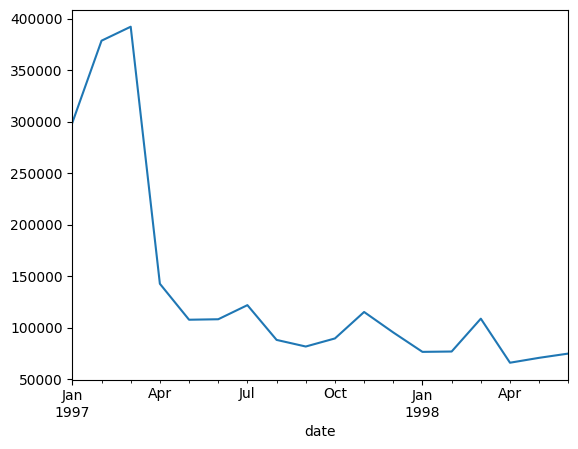

In [29]:
new_df.reset_index() \
        .set_index('date') \
        .resample('MS')['price'] \
        .sum() \
        .plot()


In [30]:
ids = new_df['customer_id'].unique()
#ids_selected = ids[0:10]

In [31]:
ids

<IntegerArray>
[  455,   713,   908,   925,  1101,  1186,  1225,  1381,  1401,  1753,
 ...
  7781,  7163,  8297, 23251, 19946,  9362, 18847,  9651, 15238, 15003]
Length: 23570, dtype: Int64

In [32]:
ids_selected = ids[0:10]

In [33]:
ids_selected

<IntegerArray>
[455, 713, 908, 925, 1101, 1186, 1225, 1381, 1401, 1753]
Length: 10, dtype: Int64

In [35]:
cdnow_cust_id_subset_df = new_df[
    new_df['customer_id'].isin(ids_selected)
].groupby(['customer_id', 'date']) \
 .sum() \
 .reset_index()


In [36]:
cdnow_cust_id_subset_df

,customer_id,date,quantity,price
0,455,1997-01-02,1,0.0
1,713,1997-01-03,1,0.0
2,908,1997-01-04,1,0.0
3,925,1997-01-04,1,0.0
4,1101,1997-01-05,1,0.0
5,1186,1997-01-05,1,0.0
6,1225,1997-01-05,1,0.0
7,1381,1997-01-06,1,0.0
8,1401,1997-01-06,1,0.0
9,1753,1997-01-07,1,0.0


/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


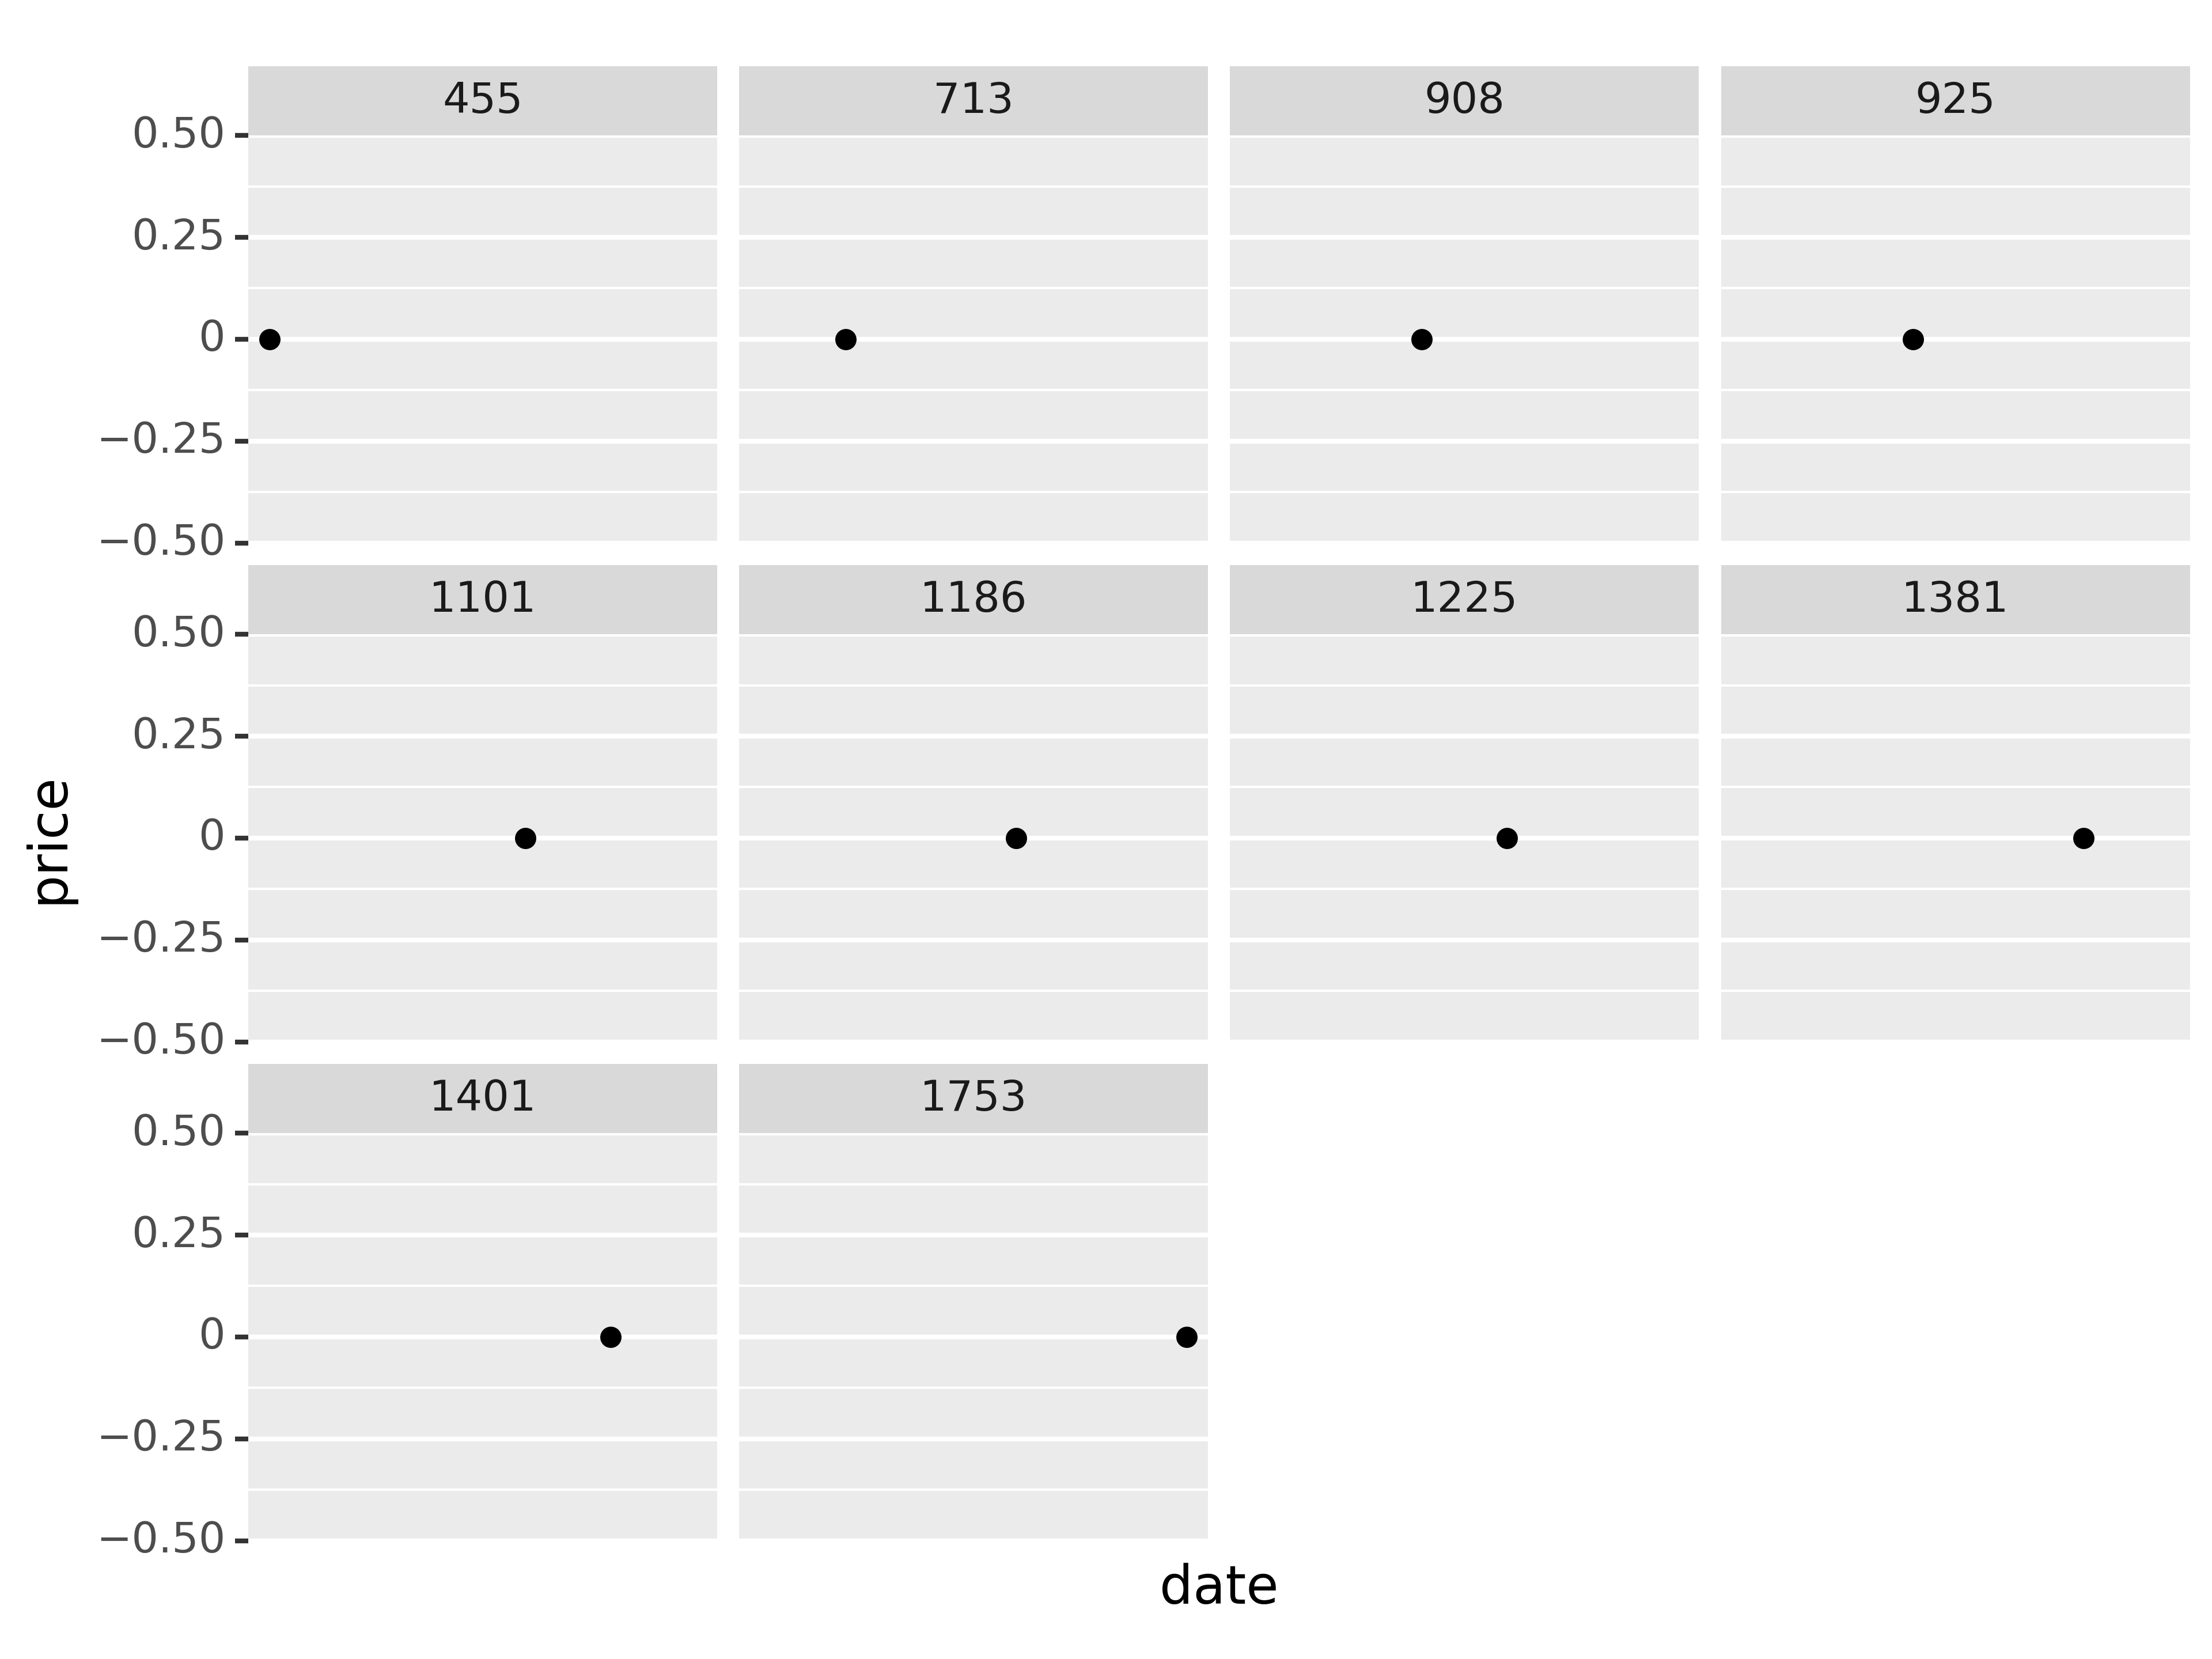

<Figure Size: (1920 x 1440)>

In [47]:
pn.ggplot(
    data=cdnow_cust_id_subset_df,
    mapping=pn.aes('date', 'price', group='customer_id')
) + \
pn.geom_line() + \
pn.geom_point() + \
pn.facet_wrap('customer_id') + \
pn.scale_x_date(
    date_breaks="1 year",
    date_labels="%y"
)


In [63]:
#-------Machine Learning------

n_days = 90
max_date = new_df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = 'd')

In [64]:
cutoff

Timestamp('1998-04-01 00:00:00')

In [65]:
temporal_in_df = new_df[new_df['date'] <= cutoff]

In [66]:
temporal_in_df

,customer_id,date,quantity,price
0,455,1997-01-02,1,0.00
1,713,1997-01-03,1,0.00
2,908,1997-01-04,1,0.00
3,925,1997-01-04,1,0.00
4,1101,1997-01-05,1,0.00
...,...,...,...,...
69653,7592,1997-02-03,47,563.59
69654,22279,1997-07-27,56,831.35
69655,8529,1997-02-28,56,756.47
69656,22279,1997-07-26,63,915.10


In [67]:
temporal_out_df = new_df[new_df['date'] > cutoff]

In [68]:
temporal_out_df

,customer_id,date,quantity,price
16,3044,1998-04-17,1,0.00
119,8304,1998-04-15,1,19.00
412,4320,1998-05-24,1,11.02
413,4320,1998-06-02,1,11.02
416,23035,1998-04-10,1,11.02
...,...,...,...,...
69628,9172,1998-04-06,28,409.22
69629,16175,1998-04-09,29,371.71
69631,2275,1998-05-29,30,359.70
69641,10197,1998-06-10,37,587.63


In [69]:
 targets_df = temporal_out_df\
	.drop('quantity', axis=1)\
	.groupby('customer_id')\
	.sum()\
	.rename({'price':'Spend_90_total'}, axis = 1)\
	.assign(spend_90_flag = 1)

<ipython-input-69-29f29eaea7b5>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [70]:
targets_df

,Spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [85]:

#Make recency(date) features from in data

recency_features_df = temporal_in_df\
[['customer_id', 'date']]\
    .groupby('customer_id')\
    .apply(
        lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, 'day')
    )\
	.to_frame()\
	.set_axis(["recency"], axis =1)

In [86]:
recency_features_df

,recency
customer_id,
1,-545.0
2,-534.0
3,-217.0
4,-200.0
5,-178.0
...,...
23566,-462.0
23567,-462.0
23568,-434.0


In [87]:
#Make frequency features from in data

frequency_feature_df= temporal_in_df\
	[['customer_id','date']]\
	.groupby('customer_id')\
	.count()\
	.set_axis(['frequency'],axis=1)

In [88]:
frequency_feature_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [91]:
#Make price(monetory) features from in data

price_features_df = temporal_in_df\
	.groupby('customer_id')\
	.aggregate(
		{
			'price':['sum','mean']
		}
	)\
	.set_axis(['price_sum', 'price_mean'], axis=1)

In [92]:
price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


In [98]:
import pandas as pd

# Assuming recency_features_df, frequency_feature_df, price_features_df, and targets_df are defined DataFrames

# Concatenate feature dataframes
features_df = pd.concat(
    [recency_features_df, frequency_feature_df, price_features_df],
    axis=1
)

# Merge with targets_df
merged_df = features_df.merge(
    targets_df,
    left_index=True,
    right_index=True,
    how="left"
).fillna(0)

# Now merged_df should be the DataFrame you want


In [99]:
merged_df

,recency,frequency,price_sum,price_mean,Spend_90_total,spend_90_flag
customer_id,,,,,,
1,-545.0,1,11.77,11.770000,0.00,0.0
2,-534.0,2,89.00,44.500000,0.00,0.0
3,-217.0,5,139.47,27.894000,16.99,1.0
4,-200.0,4,100.50,25.125000,0.00,0.0
5,-178.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-462.0,1,36.00,36.000000,0.00,0.0
23567,-462.0,1,20.97,20.970000,0.00,0.0
23568,-434.0,3,121.70,40.566667,0.00,0.0
